<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q -d /content /content/drive/MyDrive/archive.zip

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt

class ImageDataset(Dataset):
    def __init__(self, root_dir, image_size):
        self.root_dir = root_dir
        self.image_paths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
        ]
        self.transform = tt.Compose([
            tt.Resize((image_size, image_size)),
            tt.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        image = self.transform(image)
        return image

def get_dataloader(image_size, batch_size, device):
    """
    Builds dataloader for training data.
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    dataset = ImageDataset('/content/faces_dataset_small', image_size)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    return dataloader

In [5]:
import matplotlib.pyplot as plt
import torchvision

def show_batch(images, n=8):

    images = images[:n]
    grid_img = torchvision.utils.make_grid(images.cpu(), nrow=n, normalize=True)
    plt.figure(figsize=(15, 3))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [6]:
image_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_loader = get_dataloader(image_size, 32, device)

cuda


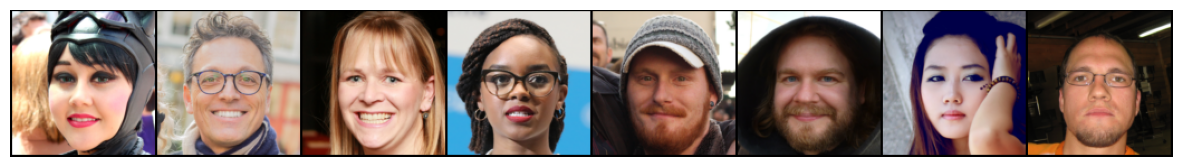

In [7]:
images = next(iter(train_loader))
show_batch(images)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [8]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 64, 64)
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 32, 32)
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 512, kernel_size=4, stride=2, padding=1),  # -> (512, 16, 16)
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=16, stride=1, padding=0),  # -> (1, 1, 1)
    nn.Flatten(),
    nn.Sigmoid()  # -> (1,)
)

In [9]:
latent_size = 128

x = torch.randn(1, 3, image_size, image_size)
out = discriminator(x)
print(out)

tensor([[0.3664]], grad_fn=<SigmoidBackward0>)


In [10]:
import torch.nn as nn

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0),  # -> (512, 4, 4)
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 8, 8)
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 16, 16)
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # -> (3, 32, 32)
    nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1),  # -> (3, 64, 64)
    nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1),  # -> (3, 128, 128)
    nn.Sigmoid()
)

In [11]:
z = torch.randn(1, latent_size, 1, 1)
fake_img = generator(z)
print(fake_img)

tensor([[[[0.4839, 0.4843, 0.4880,  ..., 0.4852, 0.4877, 0.4853],
          [0.4843, 0.4855, 0.4729,  ..., 0.4876, 0.4812, 0.4863],
          [0.4836, 0.4835, 0.4900,  ..., 0.4852, 0.4927, 0.4816],
          ...,
          [0.4853, 0.4919, 0.4801,  ..., 0.4836, 0.4785, 0.4875],
          [0.4825, 0.4859, 0.4879,  ..., 0.4827, 0.4833, 0.4843],
          [0.4848, 0.4843, 0.4881,  ..., 0.4874, 0.4876, 0.4810]],

         [[0.5142, 0.5153, 0.5150,  ..., 0.5170, 0.5116, 0.5139],
          [0.5183, 0.5179, 0.5198,  ..., 0.5210, 0.5129, 0.5140],
          [0.5152, 0.5162, 0.5065,  ..., 0.5196, 0.5136, 0.5126],
          ...,
          [0.5203, 0.5230, 0.5216,  ..., 0.5145, 0.5253, 0.5159],
          [0.5131, 0.5193, 0.5121,  ..., 0.5140, 0.5086, 0.5159],
          [0.5150, 0.5252, 0.5124,  ..., 0.5207, 0.5100, 0.5179]],

         [[0.4654, 0.4664, 0.4646,  ..., 0.4654, 0.4649, 0.4669],
          [0.4658, 0.4586, 0.4667,  ..., 0.4585, 0.4678, 0.4653],
          [0.4642, 0.4736, 0.4747,  ..., 0

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np

In [13]:
for i, batch in enumerate(train_loader):
    print(f"Batch {i}: shape={batch[0].shape}, min={batch[0].min()}, max={batch[0].max()}")
    if i > 5:
        break

Batch 0: shape=torch.Size([3, 128, 128]), min=0.0, max=0.9764705896377563
Batch 1: shape=torch.Size([3, 128, 128]), min=0.05098039284348488, max=1.0
Batch 2: shape=torch.Size([3, 128, 128]), min=0.0941176488995552, max=1.0
Batch 3: shape=torch.Size([3, 128, 128]), min=0.003921568859368563, max=0.9843137264251709
Batch 4: shape=torch.Size([3, 128, 128]), min=0.0, max=0.8470588326454163
Batch 5: shape=torch.Size([3, 128, 128]), min=0.007843137718737125, max=0.9529411792755127
Batch 6: shape=torch.Size([3, 128, 128]), min=0.027450980618596077, max=0.9411764740943909


In [14]:
print("Generator parameters:", len(list(generator.parameters())))
print("Discriminator parameters:", len(list(discriminator.parameters())))

Generator parameters: 18
Discriminator parameters: 12


In [15]:
batch_size = 64

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np

image_size = 128
latent_size = 128
batch_size = 128
lr = 0.0001
epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = get_dataloader(image_size, batch_size, device)

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

generator = model['generator'].to(device)
discriminator = model['discriminator'].to(device)
model["discriminator"].train()
model["generator"].train()
g_criterion = criterion['generator']
d_criterion = criterion['discriminator']

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

for epoch in range(epochs):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for real_images in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", total=len(train_loader), leave=True):

        d_optimizer.zero_grad()

        real_images = real_images.to(device)

        real_preds = discriminator(real_images)
        real_targets = torch.ones(real_images.size(0), 1, device=device)
        real_loss = d_criterion(real_preds, real_targets)
        cur_real_score = torch.mean(real_preds).item()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(latent)

        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        fake_preds = discriminator(fake_images)
        fake_loss = d_criterion(fake_preds, fake_targets)
        cur_fake_score = torch.mean(fake_preds).item()

        real_score_per_epoch.append(cur_real_score)
        fake_score_per_epoch.append(cur_fake_score)

        loss_d = real_loss + fake_loss
        loss_d.backward()
        d_optimizer.step()
        loss_d_per_epoch.append(loss_d.item())

        g_optimizer.zero_grad()
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

        fake_images = generator(latent)
        preds = discriminator(fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss_g = g_criterion(preds, targets)
        loss_g.backward()
        g_optimizer.step()
        loss_g_per_epoch.append(loss_g.item())


    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))
    real_scores.append(np.mean(real_score_per_epoch))
    fake_scores.append(np.mean(fake_score_per_epoch))

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]), flush=True)



Epoch 1/10:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 100.0000, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


Epoch 2/10:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [17]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(generated):
    images = generated.detach().cpu()  # просто перемещаем на CPU
    grid = vutils.make_grid(images, nrow=2, padding=2, normalize=False)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(grid.permute(1, 2, 0))  # C×H×W → H×W×C
    plt.show()


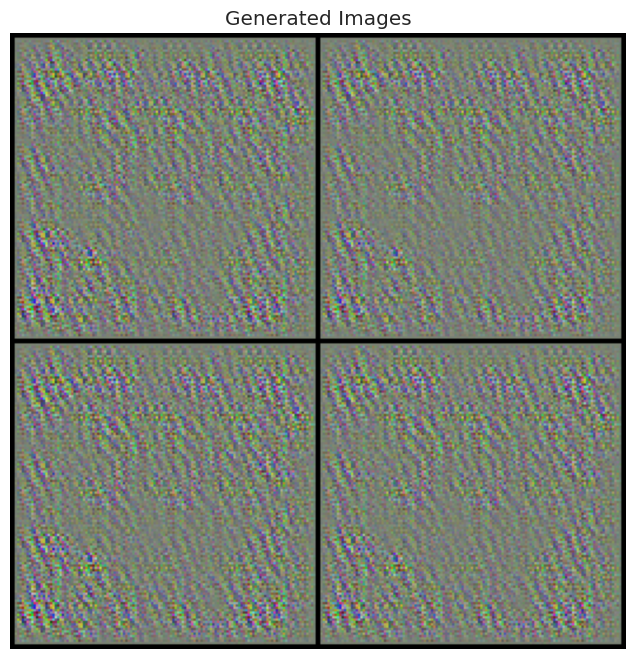

In [19]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: